In [1]:
import radiomics
import ants
import torchio as tio

import os
from tqdm import tqdm
import pandas as pd

import SimpleITK as sitk
import pydicom as pydicom

import numpy as np
from scipy.spatial import distance

import gui
import registration_gui as rgui

import matplotlib.pyplot as plt

import concurrent.futures
import threading

import seaborn as sns

NUM_WORKERS = 16

In [2]:
ROI = {
    'csf':[1],
    'gm':[2], #select 2 and do not include anything else; 2 = Gray Matter
    'wm':[3], #select 3 and do not include anything else; 3 = White Matter
    'gwm':[2,3], 
    'brain':[1,2,3,4] #In FAST FSL, if you are segmenting T2-weighted images, you may need to select 4 classes so that dark non-brain matter is processed correctly
}

In [3]:
DATA_DIR = r"/home/thulasiseetha/research/dataset/curated/BrainMR"
SOI = ["t2w_nfs", "t2w_fs"]


# Dataset Visualization

In [4]:
pid = os.listdir(os.path.join(DATA_DIR, "t2w_fs"))[0]

In [5]:
fs_img = sitk.ReadImage(os.path.join(DATA_DIR, "t2w_fs", pid, "img.nii.gz"))
fs_mask = sitk.ReadImage(os.path.join(DATA_DIR, "t2w_fs", pid, "mask.nii.gz"))
nfs_img = sitk.ReadImage(os.path.join(DATA_DIR, "t2w_nfs" , pid, "img.nii.gz"))
nfs_mask = sitk.ReadImage(os.path.join(DATA_DIR, "t2w_nfs", pid, "mask.nii.gz"))

fs_img_arr = sitk.GetArrayFromImage(fs_img)
fs_mask_arr = sitk.GetArrayFromImage(fs_mask)
nfs_img_arr = sitk.GetArrayFromImage(nfs_img)
nfs_mask_arr = sitk.GetArrayFromImage(nfs_mask)

In [6]:
img = nfs_img
mask = nfs_mask

<IPython.core.display.Javascript object>


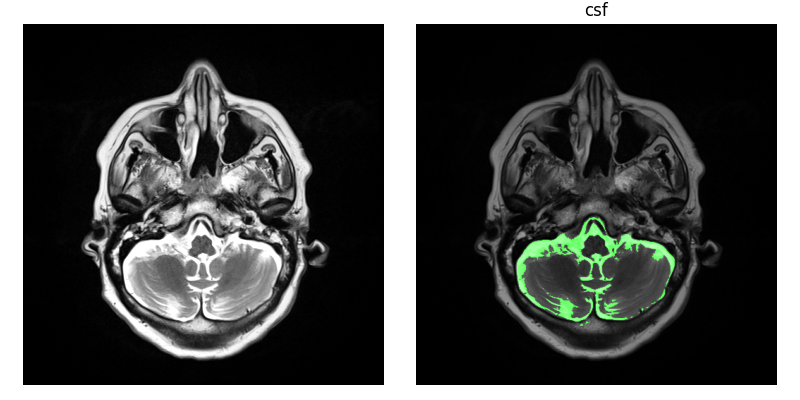

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<IPython.core.display.Javascript object>


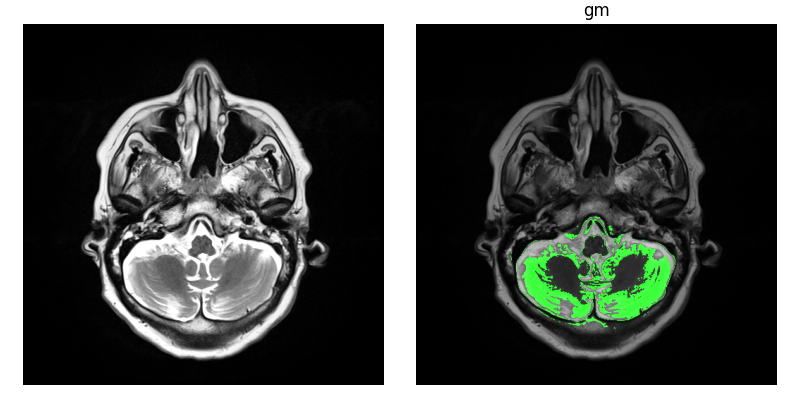

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<IPython.core.display.Javascript object>


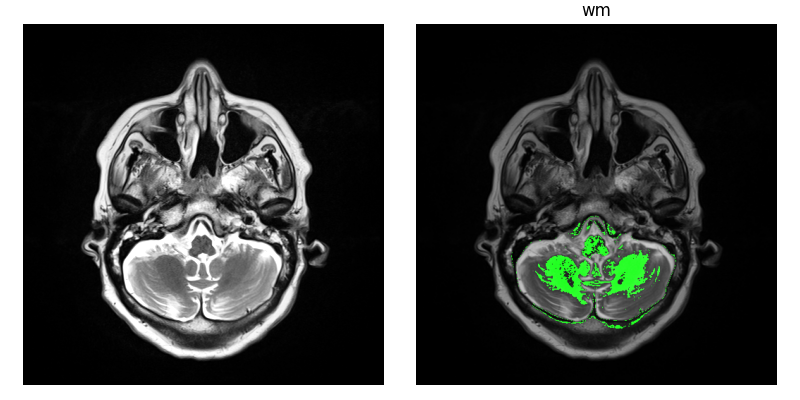

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<IPython.core.display.Javascript object>


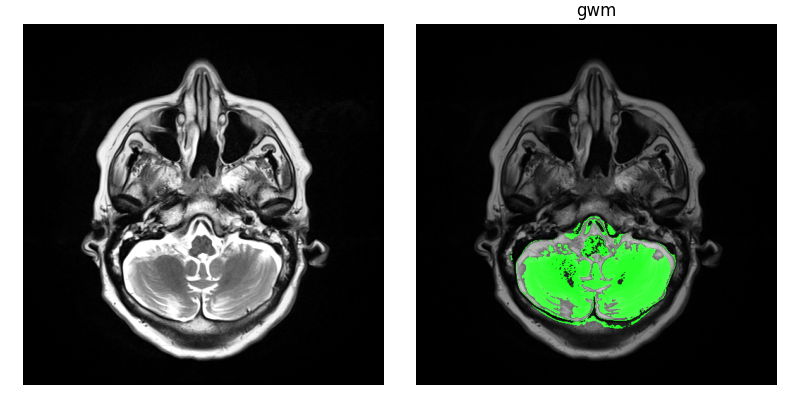

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<IPython.core.display.Javascript object>


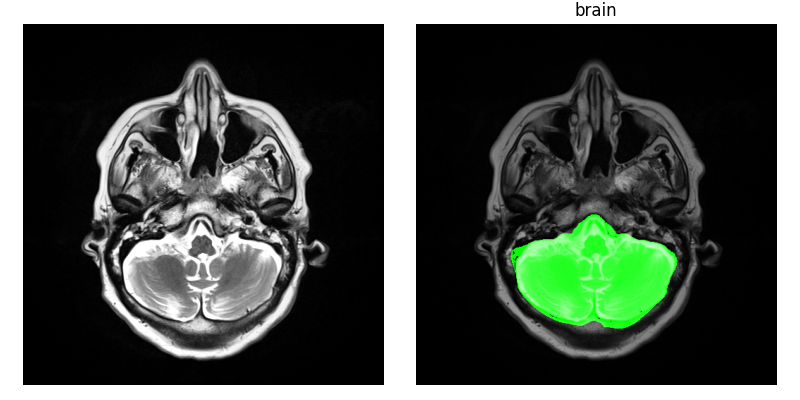

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [7]:
%matplotlib notebook

for tissue in ROI:
    
    binary_masks = []
    for label in ROI[tissue]:
        binary_masks.append(sitk.BinaryThreshold(mask, label, label))
        
    binary_mask = sum(binary_masks)
    binary_mask = binary_mask>0
    img255 = sitk.RescaleIntensity(img)
    overlayImg255 = sitk.LabelOverlay(img255, binary_mask, opacity=0.1)
    gui.MultiImageDisplay([img255,overlayImg255], window_level_list = [None,None], figure_size=(8, 4), shared_slider=True, title_list=[None,tissue])
    

# Dataset Statistics

In [8]:
df = {"pid":[], "sequence":[], "spacing_x":[], "spacing_y":[], "spacing_z":[]}

for sequence in SOI:
    
    pids = os.listdir(os.path.join(DATA_DIR, sequence))
    
    for pid in pids:
    
        img = sitk.ReadImage(os.path.join(DATA_DIR, sequence , pid, "img.nii.gz"))
        
        img_arr = sitk.GetArrayFromImage(img)
        
        spacing_x, spacing_y, spacing_z = img.GetSpacing()

        df["pid"].append(pid)
        df["sequence"].append(sequence)
        df["spacing_x"].append(spacing_x)
        df["spacing_y"].append(spacing_y)
        df["spacing_z"].append(spacing_z)
      
        
df = pd.DataFrame.from_dict(df)

for sequence in SOI:
    print(sequence, "median_spacing", df[df.sequence==sequence]["spacing_x"].median().round(2), df[df.sequence==sequence]["spacing_y"].median().round(2), df[df.sequence==sequence]["spacing_z"].median().round(2))

t2w_nfs median_spacing 0.47 0.47 3.3
t2w_fs median_spacing 0.47 0.47 3.3


# N4Bias Field Correction

In [9]:
class BiasFieldCorrection(object):
    
    def __init__(self, roi = "default"):
        
        assert roi in ["default", "brain", "gwm"]
        
        self.labels = ROI[roi] if roi in ROI else []
        
    def __call__(self, sitk_img, sitk_mask):
        
        n = sitk_img.GetDimension()

        origin = sitk_img.GetOrigin()
        spacing = sitk_img.GetSpacing()
        direction = sitk_img.GetDirection()
        
        img_arr = sitk.GetArrayFromImage(sitk_img) # Z, Y, X
        ants_img = ants.from_numpy(img_arr.transpose(-1, -2, -3).astype(np.float32), origin, spacing, np.array(direction).reshape(-1, n))

        if self.labels:
            mask_arr = sitk.GetArrayFromImage(sitk_mask)
            roi_mask = np.logical_or.reduce([mask_arr==i for i in self.labels]).astype(np.uint8)

            ants_mask = ants.from_numpy(roi_mask.transpose(-1, -2, -3).astype(np.float32), origin, spacing, np.array(direction).reshape(-1, n))
            
            corr_ants_img = ants.n4_bias_field_correction(ants_img, ants_mask)
        else:
            corr_ants_img = ants.n4_bias_field_correction(ants_img)
            
        corr_img_arr = corr_ants_img.numpy().transpose(-1, -2, -3) # X, Y, Z to Z, Y, X

        corr_sitk_img = sitk.GetImageFromArray(corr_img_arr)
        corr_sitk_img.CopyInformation(sitk_img)
        
        return corr_sitk_img, sitk_mask
        

# Bias Corrected Image Visualization

N4 bias correction using - default mask


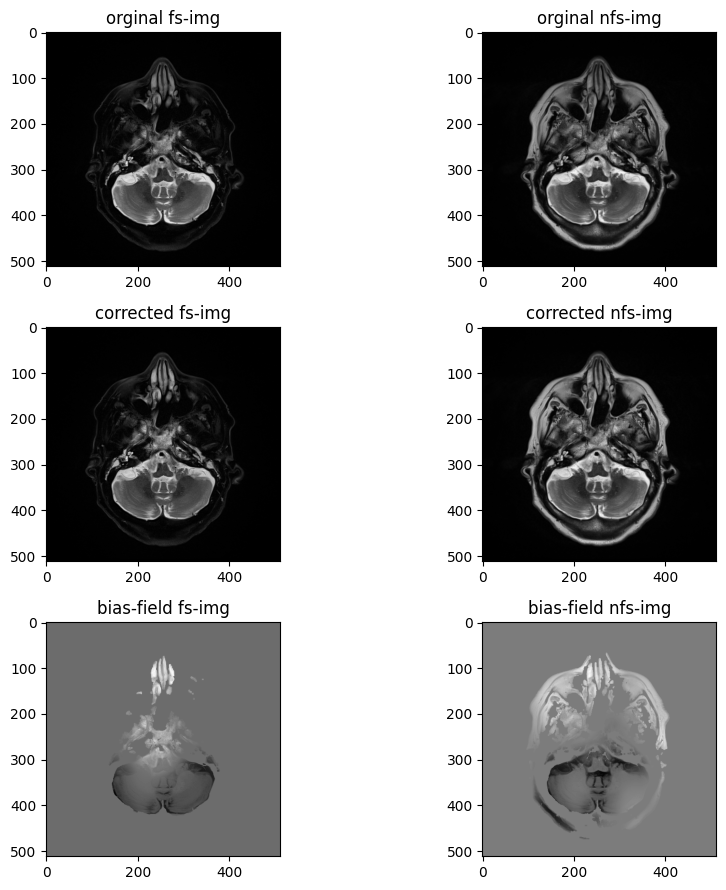

N4 bias correction using - brain mask


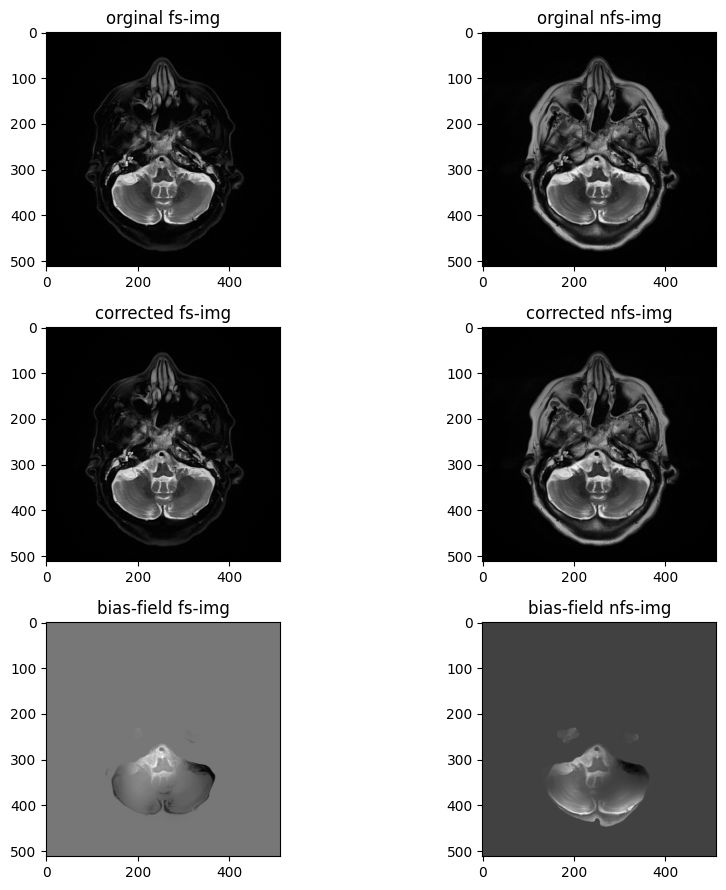

N4 bias correction using - gwm mask


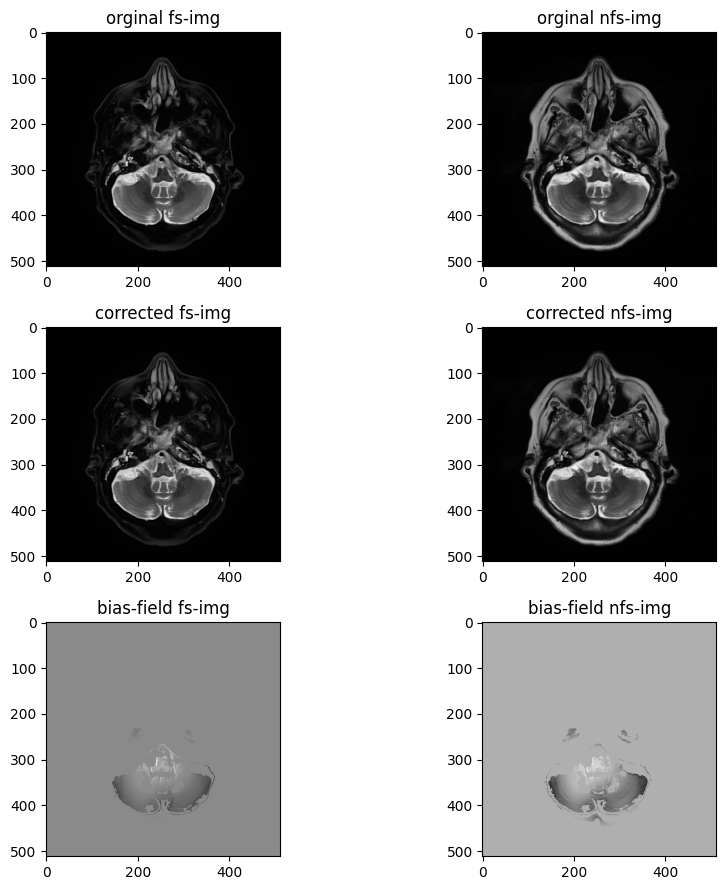

In [10]:
%matplotlib inline

for correction_roi in ["default", "brain", "gwm"]:
    
    fig, axes = plt.subplots(3,2, figsize=(10,9))
    
        
    print(f"N4 bias correction using - {correction_roi} mask")

    corr_fs_img, fs_mask = BiasFieldCorrection(correction_roi)(fs_img, fs_mask)
    corr_nfs_img, nfs_mask = BiasFieldCorrection(correction_roi)(nfs_img, nfs_mask)

        
    corr_fs_img_arr = sitk.GetArrayFromImage(corr_fs_img)
    corr_nfs_img_arr = sitk.GetArrayFromImage(corr_nfs_img)
    
    i = len(fs_img_arr)//2
    

    axes[0,0].imshow(fs_img_arr[i], cmap='gray')
    axes[0,0].set_title("orginal fs-img")
    axes[1,0].imshow(corr_fs_img_arr[i], cmap='gray')
    axes[1,0].set_title(f"corrected fs-img")
    axes[2,0].imshow((corr_fs_img_arr-fs_img_arr)[i], cmap='gray')
    axes[2,0].set_title("bias-field fs-img")
    
    axes[0,1].imshow(nfs_img_arr[i], cmap='gray')
    axes[0,1].set_title("orginal nfs-img")
    axes[1,1].imshow(corr_nfs_img_arr[i], cmap='gray')
    axes[1,1].set_title(f"corrected nfs-img")
    axes[2,1].imshow((corr_nfs_img_arr-nfs_img_arr)[i], cmap='gray')
    axes[2,1].set_title("bias-field nfs-img")
    plt.tight_layout()
    plt.show()
    
    
    
    

# Normalization

In [11]:
class Normalize(object):
    
    def __init__(self, roi="brain"): #roi which will be used to normalize
        
        assert roi in ROI
        
        self.labels = ROI[roi]
        
    def __call__(self, sitk_img, sitk_mask):
        
        
        img_arr = sitk.GetArrayFromImage(sitk_img)
        mask_arr = sitk.GetArrayFromImage(sitk_mask)
        
        roi_mask = np.logical_or.reduce([mask_arr==i for i in self.labels])

        mean = img_arr[roi_mask==1].mean()
        std = img_arr[roi_mask==1].std()

        img_arr = (img_arr - mean)/std
        img_arr[img_arr<-3] = -3
        img_arr[img_arr>3] = 3
  
        norm_sitk_img = sitk.GetImageFromArray(img_arr)
        norm_sitk_img.CopyInformation(sitk_img)
        
        return norm_sitk_img, sitk_mask
        


# Normalized Image Visualization

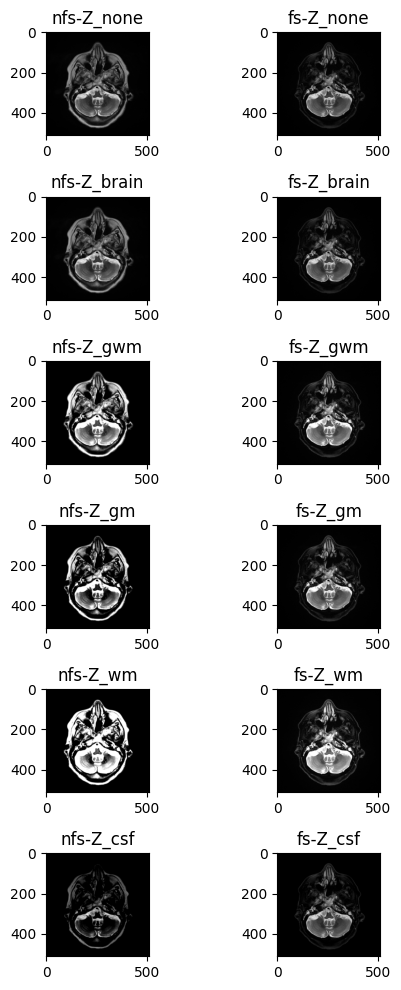

In [12]:
%matplotlib inline

corr_fs_img, _ = BiasFieldCorrection("brain")(fs_img, fs_mask) #only brain-based N4Bias correction
corr_nfs_img, _ = BiasFieldCorrection("brain")(nfs_img, nfs_mask)

imgs = {"fs":corr_fs_img, "nfs":corr_nfs_img}
masks = {"fs":fs_mask, "nfs":nfs_mask}


fig, axes = plt.subplots(6, 2, figsize=(5,10))

for i, norm_roi in enumerate(["none", "brain", "gwm", "gm", "wm", "csf"]):
    
    for j, sequence in enumerate(["nfs", "fs"]):
        
        sitk_img = imgs[sequence]
        sitk_mask = masks[sequence]
        
        if norm_roi!="none":
            sitk_img, sitk_mask = Normalize(norm_roi)(sitk_img, sitk_mask)
        
        img_arr = sitk.GetArrayFromImage(sitk_img)
        d = len(img_arr)//2

        axes[i,j].imshow(img_arr[d], cmap='gray')
        axes[i,j].set_title(sequence+"-Z_"+norm_roi)
        
plt.tight_layout()
plt.show()
    
    
    
    

# Distribution Visualization 

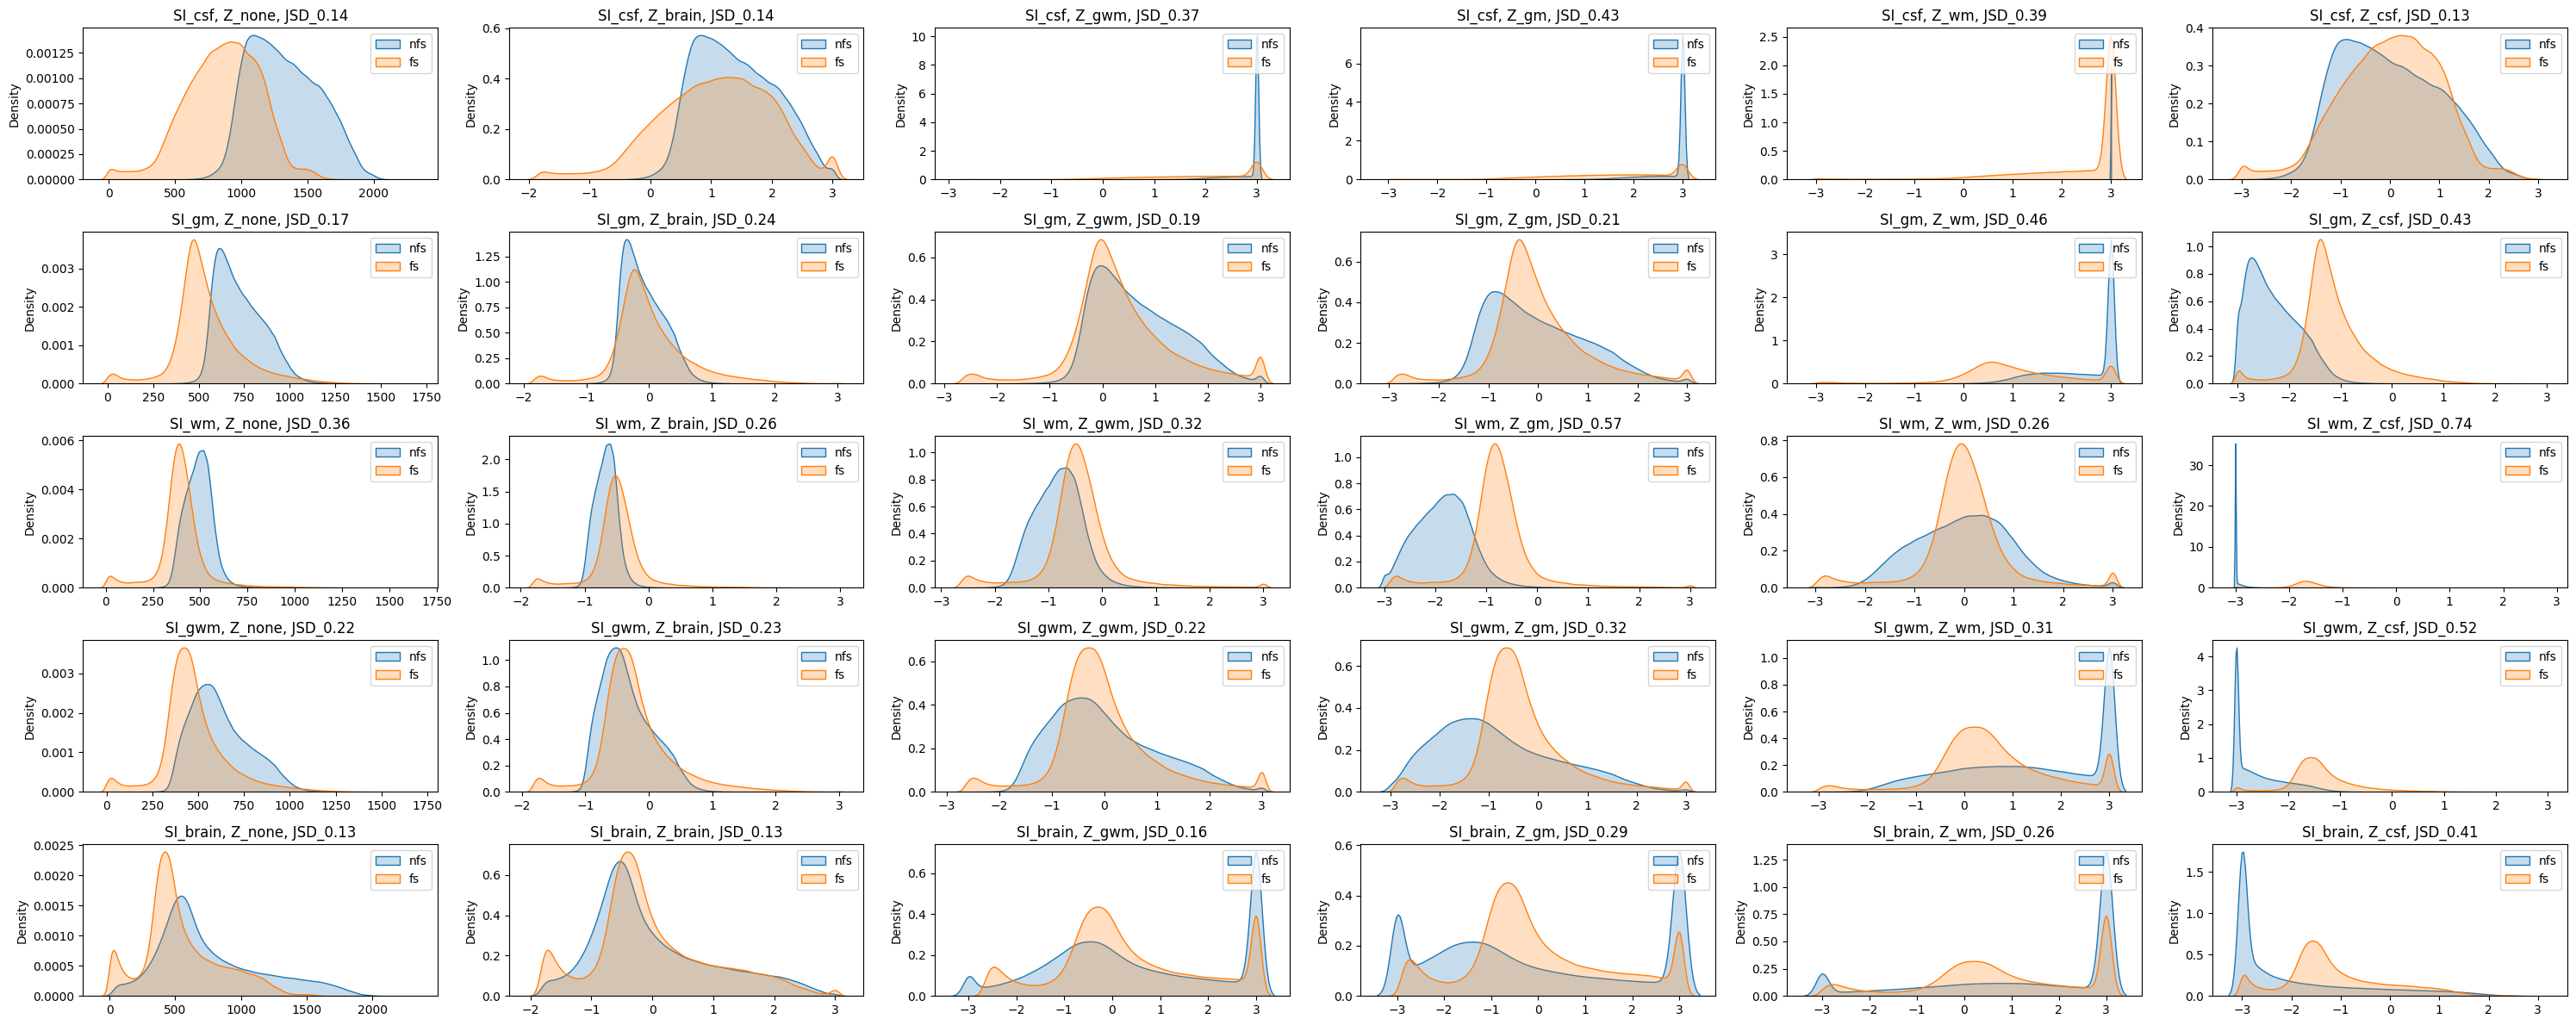

In [13]:
%matplotlib inline

fig, axes = plt.subplots(5, 6, figsize=(30,12)) #5 - # of tissues, 6 because we also consider no normalization

for i,roi in enumerate(ROI):
    
    for j, norm_roi in enumerate(["none", "brain", "gwm", "gm", "wm", "csf"]):
        
        SI = {}

        for sequence in ["nfs", "fs"]:

            sitk_img = imgs[sequence]
            sitk_mask = masks[sequence]

            if norm_roi!="none":
                sitk_img, sitk_mask = Normalize(norm_roi)(sitk_img, sitk_mask)


            img_arr = sitk.GetArrayFromImage(sitk_img)
            mask_arr = sitk.GetArrayFromImage(sitk_mask)

            roi_mask_arr = np.logical_or.reduce([mask_arr==i for i in ROI[roi]]).astype(np.uint8)
            
            SI[sequence] = img_arr[roi_mask_arr==1]
            sns.kdeplot(SI[sequence], label=sequence, fill=True, ax=axes[i,j])
        
    
        hist_fs,_ = np.histogram(SI["fs"], bins=64)
        hist_nfs,_ = np.histogram(SI["nfs"],  bins=64)
        
        jsd = distance.jensenshannon(hist_fs/len(SI["fs"]), hist_nfs/len(SI["nfs"]))
        axes[i,j].legend()
        axes[i,j].set_title(f"SI_{roi}, Z_{norm_roi}, JSD_{jsd:0.2}")
        plt.tight_layout()
plt.show()    



# Radiomics Feature Extraction

In [14]:
featureVectors = []

In [15]:
def process(pid):
    
    global featureVectors
    
    for sequence in SOI:
        
        sitk_img = sitk.ReadImage(os.path.join(DATA_DIR, sequence , pid, "img.nii.gz"))
        sitk_mask = sitk.ReadImage(os.path.join(DATA_DIR, sequence, pid, "mask.nii.gz"))
        
        for correction_roi in ["none", "default", "brain", "gwm"]:
            
            if correction_roi!="none":
                corr_sitk_img, _ = BiasFieldCorrection(correction_roi)(sitk_img, sitk_mask)
            else:
                corr_sitk_img = sitk_img
            
            for norm_roi in ["none", "brain", "gwm", "gm", "wm", "csf"]:
                
                if norm_roi!="none":
                    zcorr_sitk_img, _ = Normalize(norm_roi)(corr_sitk_img, sitk_mask)
                else:
                    zcorr_sitk_img = corr_sitk_img
           
                for tissue in ROI:

                    binary_masks = []
                    for label in ROI[tissue]:
                        binary_masks.append(sitk.BinaryThreshold(sitk_mask, label, label))

                    binary_mask = sum(binary_masks)
                    binary_mask = binary_mask>0

                    paramFile = os.path.join('paramSettings', 'StudySettings3D.yaml')
                    extractor = radiomics.featureextractor.RadiomicsFeatureExtractor(paramFile, verbosity=True)
                    featureVector = extractor.execute(zcorr_sitk_img, binary_mask, label=1)

                    featureVector["id"] = pid
                    featureVector["sequence"] = sequence
                    featureVector["bias_correction"] = correction_roi
                    featureVector["norm_roi"] = norm_roi
                    featureVector["tissue"] = tissue

                    featureVectors.append(featureVector)



In [ ]:
# # Extracting features in parallel
# pids = os.listdir(os.path.join(DATA_DIR, SOI[0]))
# pbar = tqdm(pids, desc="Extracting radiomics features", position=0)

# with ThreadPoolExecutor(max_workers=NUM_WORKERS) as e:e.map(process, pids)

In [ ]:
# # Sequential Feature Extraction
# pids = os.listdir(os.path.join(DATA_DIR, SOI[0]))
# pbar = tqdm(pids, desc="Extracting radiomics features", position=0)

# for pid in pids:
#     process(pid)
#     pbar.update()


In [ ]:
# # Exporting extracted features as a data frame
# df = pd.DataFrame(featureVectors)
# df.to_csv("radiomicsFeatures3D.csv")